In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re

In [ ]:
# =============================================================================
# 1. Load the CSV file from the local folder
# =============================================================================

# File path to revisions dataset
file_path = "ILI_datasets/1_ILI_revisions_dataset_season_23_24.csv"

# Read the file
df = pd.read_csv(file_path)

# Convert the date columns 
df['truth_date'] = pd.to_datetime(df['truth_date'], errors='coerce')
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], errors='coerce')

In [ ]:
# =============================================================================
# 2. Revised Data Points per Country
# =============================================================================
# For each country, compare the first report (snapshot) with the final report
#  to count the number of revised data points.

df_sorted = df.sort_values(by=['country', 'truth_date', 'snapshot_date'])
first_reports = df_sorted.groupby(['country', 'truth_date'], as_index=False).first()
final_reports = df_sorted.groupby(['country', 'truth_date'], as_index=False).last()

# For each country calculate revisions 
revised_points_per_country = {}
countries = df['country'].unique()


for country in countries:
    country_first = first_reports[first_reports['country'] == country]
    country_final = final_reports[final_reports['country'] == country]
    
    # Determine common truth_dates and count revisions
    common_dates = set(country_first['truth_date']).intersection(set(country_final['truth_date']))
    revised_count = 0
    for truth_date in common_dates:
        first_value = country_first[country_first['truth_date'] == truth_date]['value'].mean()
        final_value = country_final[country_final['truth_date'] == truth_date]['value'].mean()
        if not np.isclose(first_value, final_value, atol=1e-6):
            revised_count += 1
    revised_points_per_country[country] = revised_count

print("Revised data points per country:")
for country, count in revised_points_per_country.items():
    print(f"{country}: {count}")


Revised data points per country:
AT: 3
BE: 18
HR: 8
CZ: 9
DK: 18
EE: 8
FI: 9
FR: 18
GR: 6
HU: 8
IS: 8
IE: 18
LV: 4
LT: 9
LU: 5
MT: 1
NL: 17
NO: 18
PL: 8
RO: 8
SI: 10
IT: 12


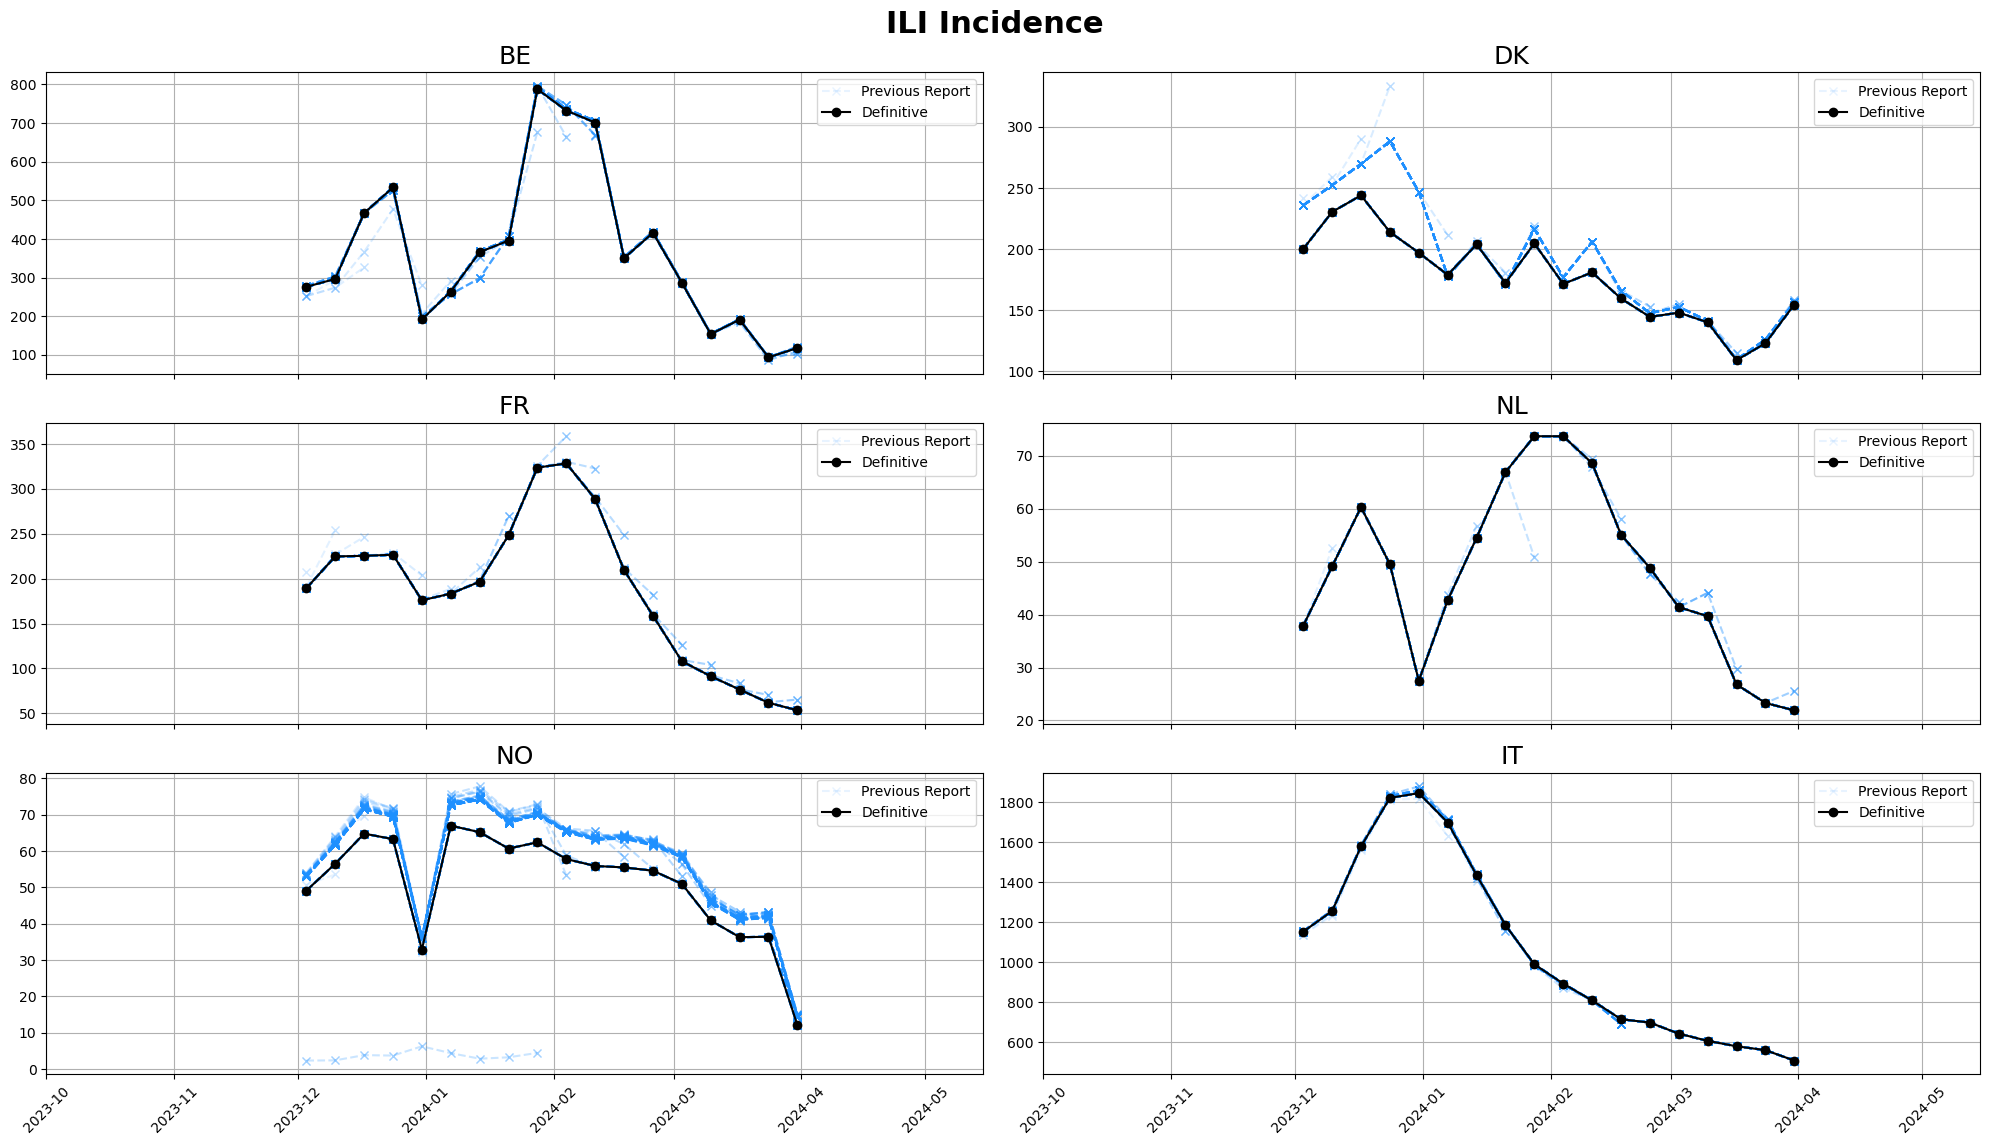

In [ ]:
# =============================================================================
# 3: Plot ILI Incidence for Selected Countries
# =============================================================================
# For each country, plot all snapshot reports and the definitive report.

# Define list of countries for plotting
ili_countries = ['BE', 'DK', 'FR', 'NL', 'NO', 'IT']

# For snapshot data, use all reports; 
# For final data, use the last report per truth_date
ili_snapshot_data = df[['country', 'truth_date', 'value', 'snapshot_date']]
ili_final_data = final_reports[['country', 'truth_date', 'value']]

# Define the time range for the plot
start_date_plot = pd.to_datetime("2023-10-01")
end_date_plot = pd.to_datetime("2024-05-15")

def plot_ili_incidence(countries, snapshot_data, final_data, title):
    num_cols = 2
    num_rows = math.ceil(len(countries) / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4), sharex=True)
    axes = axes.flatten()
    
    for idx, country in enumerate(countries):
        ax = axes[idx]
        # Filter data by country
        country_snapshot = snapshot_data[snapshot_data['country'] == country]
        country_final = final_data[final_data['country'] == country].sort_values(by="truth_date")
        
        if country_snapshot.empty and country_final.empty:
            fig.delaxes(ax)
            continue
        
        # Plot each snapshot report 
        unique_reports = sorted(country_snapshot['snapshot_date'].unique())
        label_added = False
        for i, report_date in enumerate(unique_reports):
            report_data = country_snapshot[country_snapshot['snapshot_date'] == report_date].sort_values(by="truth_date")
            # Increasing transparency
            alpha = 0.1 + 0.9 * (i / (len(unique_reports) - 1)) if len(unique_reports) > 1 else 1.0
            label = 'Previous Report' if not label_added else None
            ax.plot(report_data['truth_date'], report_data['value'], marker='x', linestyle='--',
                    color='dodgerblue', alpha=alpha, label=label)
            label_added = True
        
        # Plot the final data
        ax.plot(country_final['truth_date'], country_final['value'], marker='o', linestyle='-',
                color='black', label='Definitive')
        ax.set_title(country, fontsize=18)
        ax.grid(True)
        ax.legend()
        for label in ax.get_xticklabels():
            label.set_rotation(45)
        ax.set_xlim(start_date_plot, end_date_plot)
    
    # Remove extra subplots 
    for idx in range(len(countries), len(axes)):
        fig.delaxes(axes[idx])
    
    fig.suptitle(title, fontsize=22, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.show()

# Plot 
plot_ili_incidence(ili_countries, ili_snapshot_data, ili_final_data, "ILI Incidence")

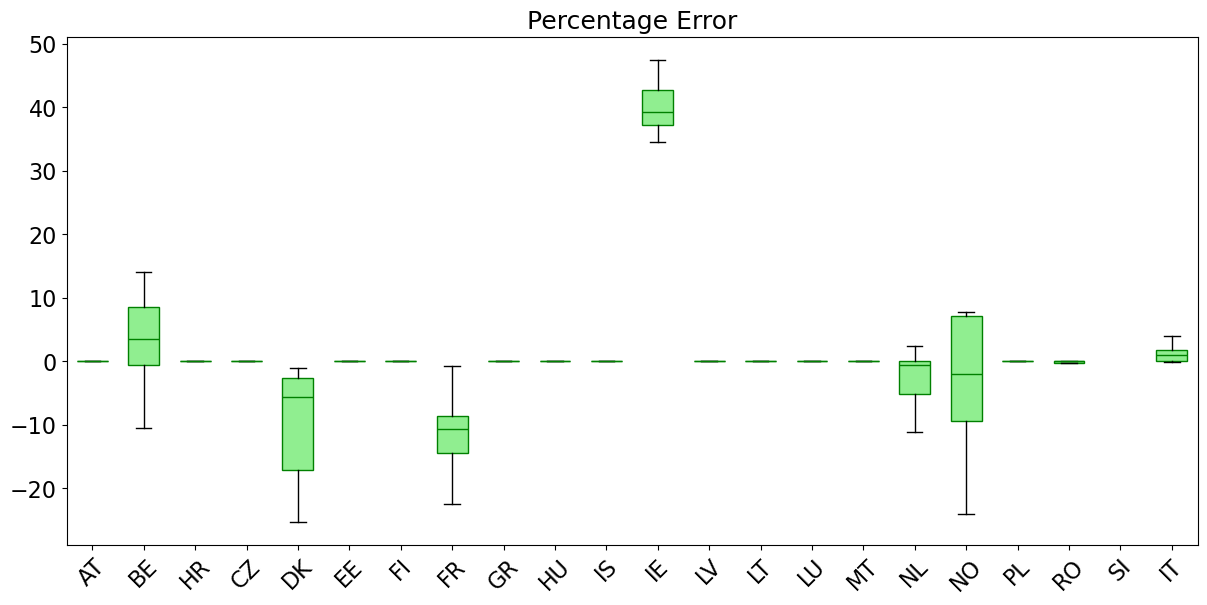

In [ ]:
# =============================================================================
# STEP 4: Calculate and Plot Error Metrics (AE and APE)
# =============================================================================
# Merge the first and final reports to compute error metrics:
# E: Error (final - snapshot)
# PE: Absolute Percentage Error

merged_data = pd.merge(first_reports, final_reports, on=['truth_date', 'country'], suffixes=('_snapshot', '_final'))
merged_data['E'] = merged_data['value_final'] - merged_data['value_snapshot']
merged_data['PE'] = 100 * (merged_data['value_final'] - merged_data['value_snapshot']) / merged_data['value_final']

# Data for boxplots of Error and Perc. Error 
boxplot_data = []
for country in df['country'].unique():
    country_merged = merged_data[merged_data['country'] == country]
    temp_df = pd.DataFrame({
        'Country': country,
        'E': country_merged['E'],
        'PE': country_merged['PE']
    })
    boxplot_data.append(temp_df)
boxplot_df = pd.concat(boxplot_data)

countries_list = boxplot_df['Country'].unique()
positions = range(len(countries_list))

# Boxplot for PE
plt.figure(figsize=(12, 6))
for idx, country in enumerate(countries_list):
    country_data = boxplot_df[boxplot_df['Country'] == country]
    plt.boxplot(country_data['PE'], positions=[idx], widths=0.6, patch_artist=True, showfliers=False,
                boxprops=dict(facecolor='lightgreen', color='green'),
                medianprops=dict(color='green'))
plt.xticks(ticks=positions, labels=countries_list, rotation=45)
plt.title('Percentage Error', fontsize=18)
plt.tight_layout()
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.show()


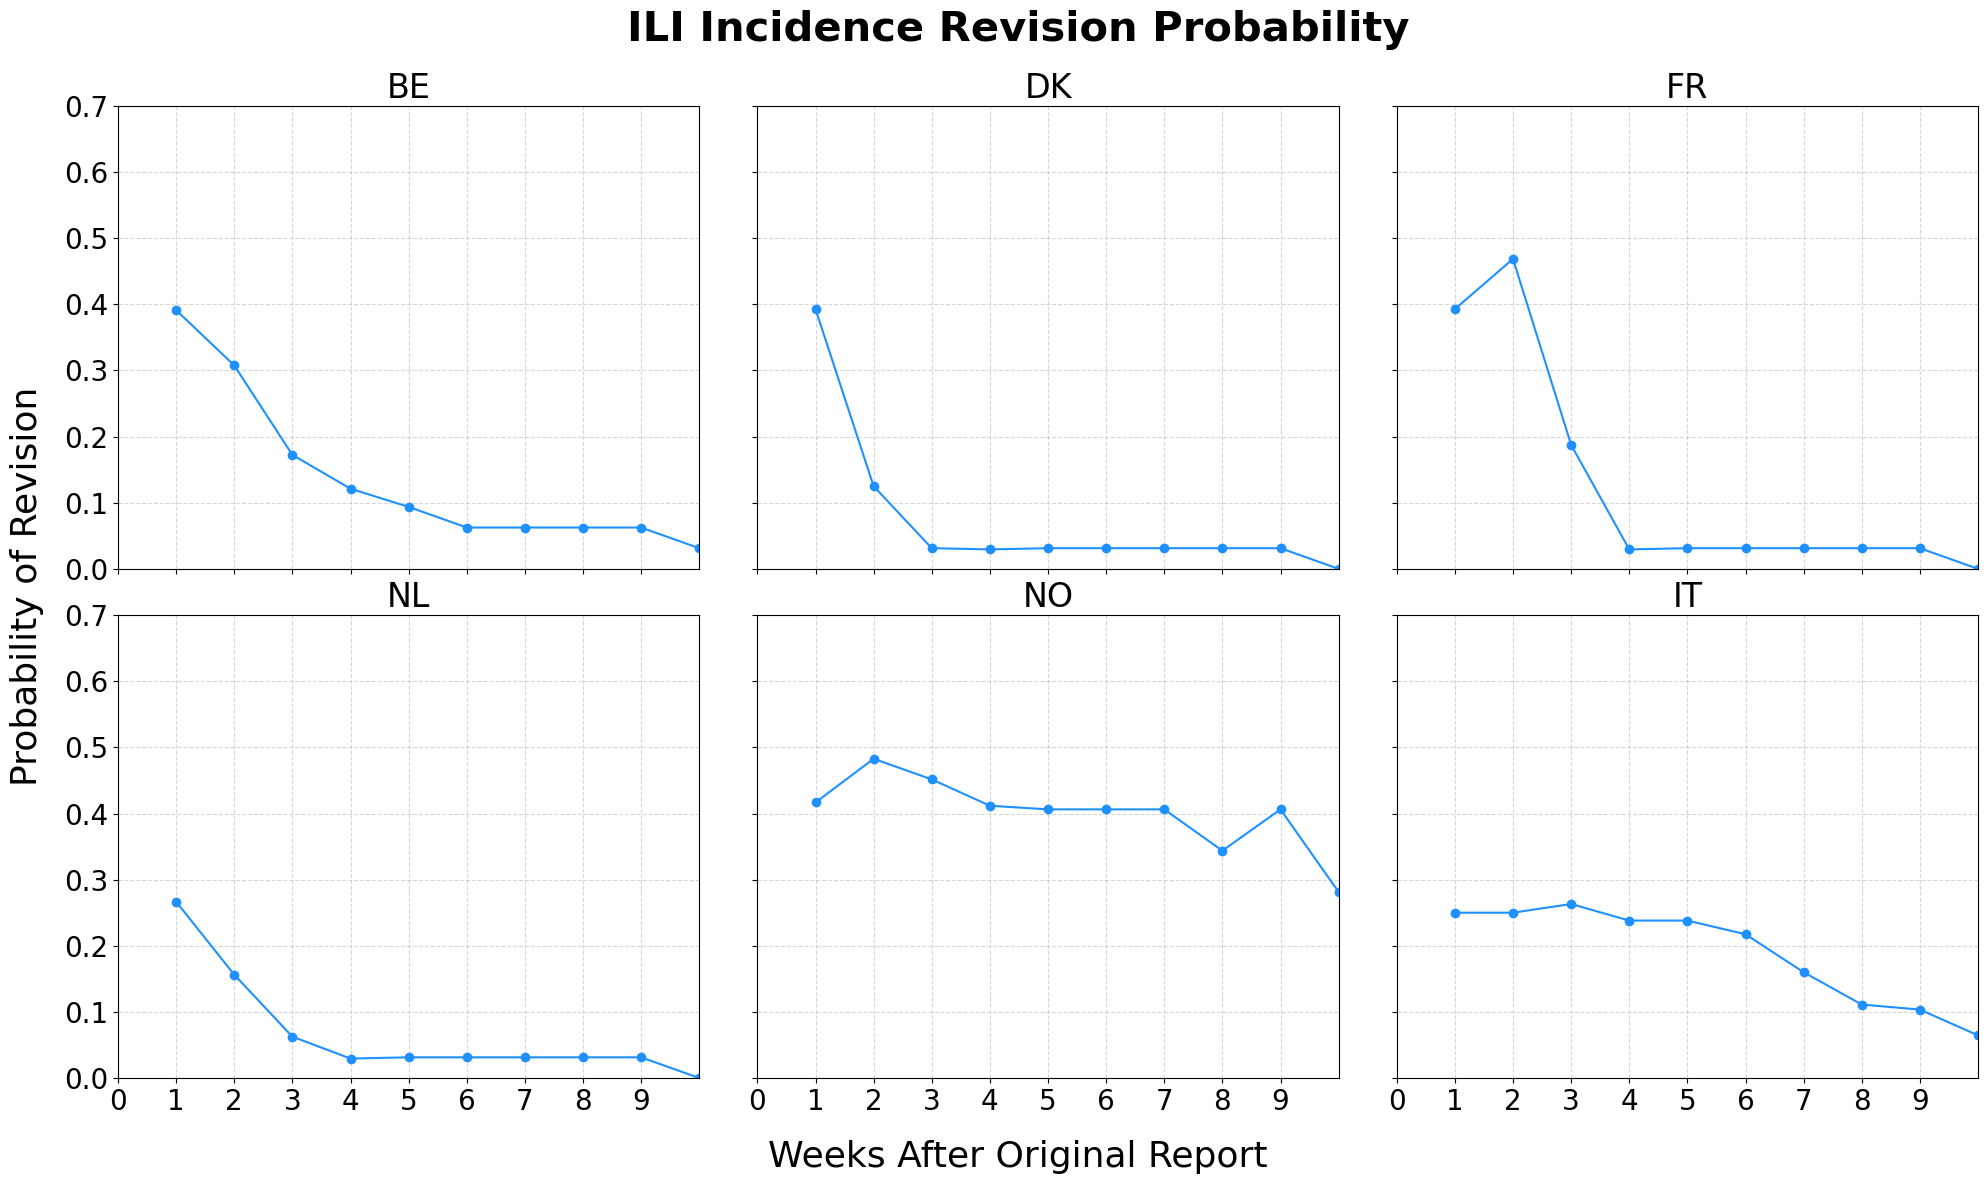

In [ ]:
# =============================================================================
# 5. Calculate and Plot the Revision Probability
# =============================================================================
# For each country, compute the probability that a revision occurs 
# as a function of the number of weeks after the truth_date.

revision_probabilities = []
selected_countries = ['BE', 'DK', 'FR', 'NL', 'NO', 'IT']

for country in selected_countries:
    country_data = df[df['country'] == country].sort_values(by=['truth_date', 'snapshot_date'])
    
    # Count revisions and total reports per week interval
    revision_counts = {}
    total_counts = {}
    
    for truth_date in country_data['truth_date'].unique():
        truth_subset = country_data[country_data['truth_date'] == truth_date].sort_values(by='snapshot_date')
        if len(truth_subset) < 2:
            continue  # Skip if only one report exists (no revision possible)
        for j in range(1, len(truth_subset)):
            prev_value = truth_subset['value'].iloc[j - 1]
            curr_value = truth_subset['value'].iloc[j]
            weeks_after = (truth_subset['snapshot_date'].iloc[j] - truth_date).days // 7
            if weeks_after <= 0:
                continue
            if weeks_after not in revision_counts:
                revision_counts[weeks_after] = 0
                total_counts[weeks_after] = 0
            if curr_value != prev_value:
                revision_counts[weeks_after] += 1
            total_counts[weeks_after] += 1

    # Calculate the probability for each week interval
    weeks_list = sorted(revision_counts.keys())
    probabilities = [revision_counts[w] / total_counts[w] if total_counts[w] > 0 else None for w in weeks_list]
    
    revision_probabilities.append(pd.DataFrame({
        'Weeks After': weeks_list,
        'Probability': probabilities,
        'Country': country
    }))

revision_prob_df = pd.concat(revision_probabilities)
revision_prob_df = revision_prob_df[revision_prob_df['Weeks After'] > 0]

# Plot the revision probability for each country
num_countries = len(selected_countries)
columns = 3
rows = math.ceil(num_countries / columns)
fig, axes = plt.subplots(rows, columns, figsize=(24, rows * 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, country in enumerate(selected_countries):
    ax = axes[idx]
    country_data = revision_prob_df[revision_prob_df['Country'] == country]
    ax.plot(country_data['Weeks After'], country_data['Probability'], marker='o', linestyle='-', 
            color='dodgerblue', label='Probability')
    ax.set_title(country, fontsize=24)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim(0, 10)
    ax.set_xticks(list(range(0, 10, 1)))
    ax.set_ylim(0, 0.7)
    ax.tick_params(axis='both', which='major', labelsize=20)

for idx in range(len(selected_countries), len(axes)):
    fig.delaxes(axes[idx])
fig.supxlabel('Weeks After Original Report', fontsize=26)
fig.supylabel('Probability of Revision', fontsize=26, x=0.08)
plt.subplots_adjust(top=0.9, bottom=0.09, hspace=0.1, wspace=0.1)
plt.suptitle('ILI Incidence Revision Probability', fontsize=30, fontweight='bold', y=0.98)
plt.show()


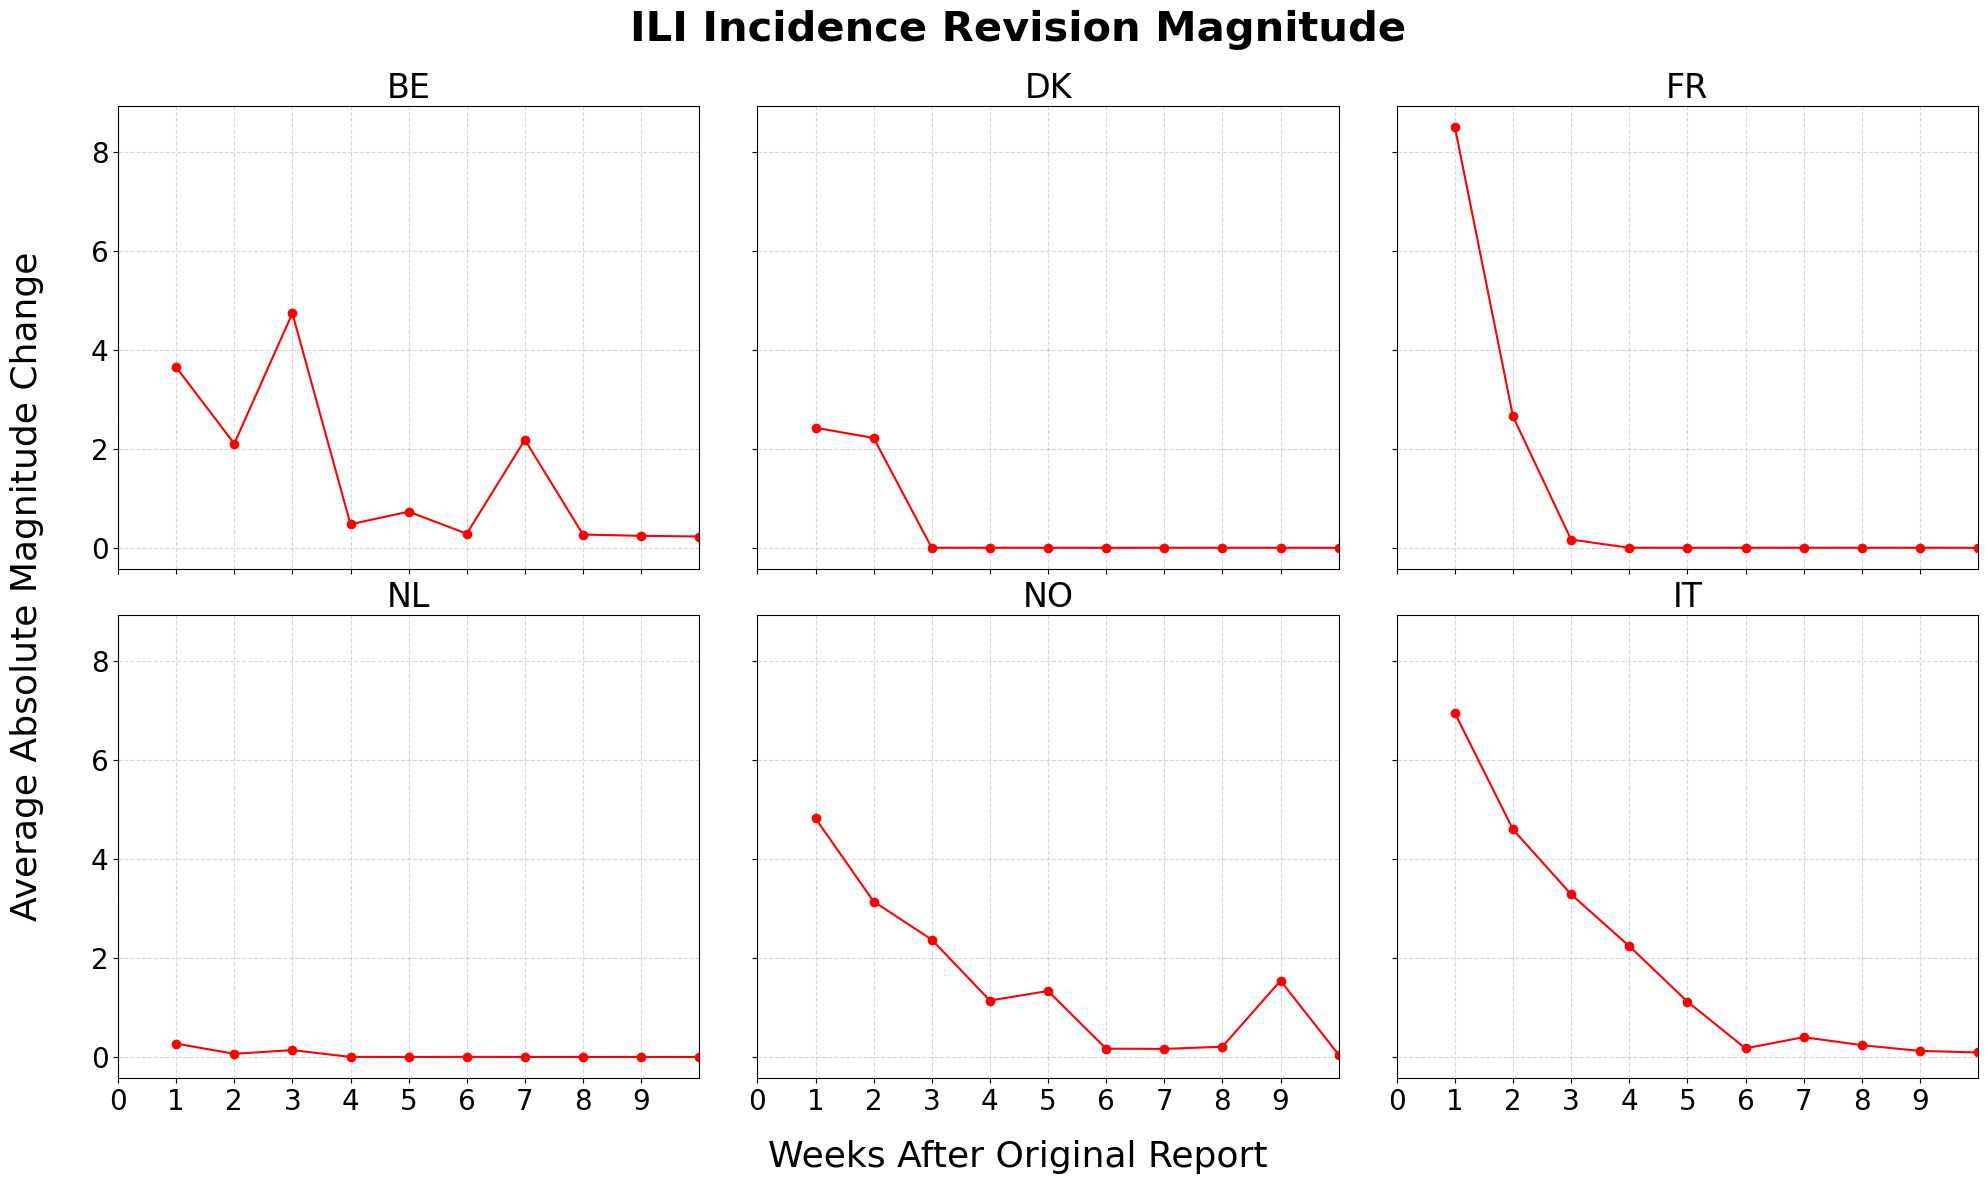

In [ ]:
# =============================================================================
# 6. Compute and Plot the Revision Magnitude
# =============================================================================
# For each country, compute the average magnitude change (difference in value)
# as a function of the number of weeks after the truth_date.

revision_magnitudes = []
for country in selected_countries:
    country_data = df[df['country'] == country].sort_values(by=['truth_date', 'snapshot_date'])
    
    # Sum magnitude changes and count revisions for each week interval
    sum_magnitude = {}
    count_magnitude = {}
    
    for truth_date in country_data['truth_date'].unique():
        truth_subset = country_data[country_data['truth_date'] == truth_date].sort_values(by='snapshot_date')
        if len(truth_subset) < 2:
            continue  # No revision if only one report exists
        for j in range(1, len(truth_subset)):
            prev_value = truth_subset['value'].iloc[j - 1]
            curr_value = truth_subset['value'].iloc[j]
            weeks_after = (truth_subset['snapshot_date'].iloc[j] - truth_date).days // 7
            if weeks_after <= 0:
                continue
            magnitude_change = curr_value - prev_value
            if weeks_after not in sum_magnitude:
                sum_magnitude[weeks_after] = 0
                count_magnitude[weeks_after] = 0
            sum_magnitude[weeks_after] += magnitude_change
            count_magnitude[weeks_after] += 1
            
    weeks_list = sorted(sum_magnitude.keys())
    avg_magnitude = [sum_magnitude[w] / count_magnitude[w] if count_magnitude[w] > 0 else None for w in weeks_list]
    
    revision_magnitudes.append(pd.DataFrame({
        'Weeks After': weeks_list,
        'Average Magnitude Change': avg_magnitude,
        'Country': country
    }))

revision_magnitude_df = pd.concat(revision_magnitudes)
revision_magnitude_df = revision_magnitude_df[revision_magnitude_df['Weeks After'] > 0]

# Plot revision magnitude for each country 
num_countries = len(selected_countries)
columns = 3
rows = math.ceil(num_countries / columns)
fig, axes = plt.subplots(rows, columns, figsize=(24, rows * 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, country in enumerate(selected_countries):
    ax = axes[idx]
    country_data = revision_magnitude_df[revision_magnitude_df['Country'] == country]
    ax.plot(country_data['Weeks After'], np.abs(country_data['Average Magnitude Change']),
            marker='o', linestyle='-', color='red', label='Avg. Magnitude Change')
    ax.set_title(country, fontsize=24)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim(0, 10)
    ax.set_xticks(list(range(0, 10, 1)))
    ax.tick_params(axis='both', which='major', labelsize=20)

for idx in range(len(selected_countries), len(axes)):
    fig.delaxes(axes[idx])
fig.supxlabel('Weeks After Original Report', fontsize=26)
fig.supylabel('Average Absolute Magnitude Change', fontsize=26, x=0.08)
plt.subplots_adjust(top=0.9, bottom=0.09, hspace=0.1, wspace=0.1)
plt.suptitle('ILI Incidence Revision Magnitude', fontsize=30, fontweight='bold', y=0.98)
plt.show()
